# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
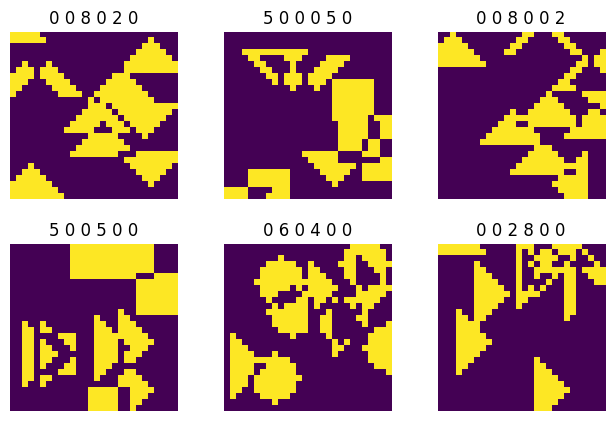

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [5]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-22 22:55:24--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-22 22:55:25--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.06s   

2025-11-22 22:55:25 (93.3 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [10]:
from pathlib import Path
from typing import Sequence, Iterator, cast
from typing_extensions import override

import numpy as np
import PIL.Image
from numpy.typing import NDArray
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset
from pathlib import Path
import pandas as pd
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

import math
import sys

# Allow custom (non-ipywidget) widgets.
if "google.colab" in sys.modules:
    from google.colab import output

    output.enable_custom_widget_manager()


In [11]:
class GSNDataset(Dataset):
    def __init__(self, csv_file, root_dir, mode='train'):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.mode = mode
        self.basic_transform = T.ToTensor() #

    def __len__(self):
        return len(self.labels_df)
    def __getitem__(self, idx):
        # 1. Get image name from the pandas df at row 'idx'
        img_name = self.labels_df.iloc[idx, 0]
        img_path = f"{self.root_dir}/{img_name}"

        # 2. Load Image
        image = Image.open(img_path).convert('L') # 'L' for grayscale

        # 3. Get the regression counts (columns 1 to 6)
        counts = self.labels_df.iloc[idx, 1:].values.astype('float32')
        counts_tensor = torch.tensor(counts)

        # 4. Calculate the classification label (The 0-134 ID)
        # You will need to write a helper function to turn 'counts' into a class ID
        class_label = self._get_class_id(counts)

        image_tensor = self.basic_transform(image)


        # Return tuple: (image, class_label, regression_counts)
        return image_tensor, class_label, counts_tensor


    def _get_class_id(self, counts):
      # 135 is 9 x 15 (15 is choose 2 from 6, 9 is how many are in a first (1 - 9))
      assert sum(1 for x in counts if x != 0) == 2
      choose_number = 0

      for i in range(5):
          if counts[i] == 0:
              choose_number += (5 - i)
          else:
              choose_number += 15 * (counts[i] - 1)
              for j in range(i + 1, 6):
                  if counts[j] == 0:
                      choose_number += 1
                  else:
                      return choose_number
      return choose_number

In [12]:
import torch
from torch import nn
class MultishapeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Required
        self.backbone  = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(64 * 28 * 28, 256), nn.ReLU()
        )

        self.head_cls = nn.Sequential(
            nn.Linear(256,256), nn.ReLU(),
            nn.Linear(256,135)
        )
        self.head_cnt = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        # 1. Extract shared features
        features = self.backbone(x)

        # 2. Classification path
        cls_logits = self.head_cls(features)
        # Specification requires NLLLoss, so we usually apply LogSoftmax here
        # or use CrossEntropyLoss (which combines LogSoftmax + NLLLoss).
        # Since spec asks for NLLLoss explicitly:
        log_probs = F.log_softmax(cls_logits, dim=1)

        # 3. Regression path
        counts = self.head_cnt(features)

        return log_probs, counts

In [14]:
import plotly.graph_objects as go
class TrainingVisualizer:
    def __init__(self, log_interval: int = 10):
        self.log_interval = log_interval
        self.train_loss_fig = self.init_line_plot(
            title="Training loss", xaxis_title="Step"
        )
        self.grad_to_weight_fig = self.init_line_plot(
            title="Gradient standard deviation to weight standard deviation ratio at 1st layer",
            xaxis_title="Step",
            yaxis_title="Gradient to weight ratio (log scale)",
            yaxis_type="log",
        )
        self.test_acc_fig = self.init_line_plot(
            title="Test accuracy", x=[], xaxis_title="Epoch", mode="lines+markers"
        )

        # Parameters related to current tracked model and its training
        self.first_linear_layer = None
        self.lr = None
        self.trace_idx = -1

    def init_line_plot(
        self,
        title: str,
        x=None,
        xaxis_title: str | None = None,
        yaxis_title: str | None = None,
        yaxis_type: str = "linear",
        mode: str = "lines",
    ) -> go.FigureWidget:
        fig = go.Figure()
        fig.update_layout(
            title=title,
            title_x=0.5,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            height=400,
            width=1500,
            margin=dict(b=10, t=60),
        )
        fig.update_yaxes(type=yaxis_type)
        # We cannot add new traces dynamically because Colab has a problem with widgets
        # from plotly (traces added dynamically are rendered twice).
        # As an ugly workaround we create a lot of empty traces and update them later
        # with actual data. Empty traces are not plotted.
        for _ in range(25):
            fig.add_trace(go.Scatter(x=x, y=[], showlegend=True, mode=mode))

        fig_widget = go.FigureWidget(fig)
        display(fig_widget)
        return fig_widget

    def track_model(
        self, model: torch.nn.Module, optimizer: torch.optim.Optimizer, lr: float
    ) -> None:
        """
        Start tracking training metrics for a new model.
        """

        # In MultishapeNet, the first linear layer for tracking gradients is the last layer of the backbone.
        if hasattr(model, 'backbone') and isinstance(model.backbone, nn.Sequential):
            # The last layer of the backbone is the nn.Linear layer before the heads
            self.first_linear_layer = model.backbone[-1]
        else:
            # Fallback to original logic if model structure changes or is different
            for field in model.__dict__["_modules"].values():
                if isinstance(field, nn.Linear):
                    self.first_linear_layer = field
                    break
                elif isinstance(field, nn.ModuleList):
                    self.first_linear_layer = field[0]
                    break

        self.lr = lr
        self.trace_idx += 1

        optim_name = type(optimizer).__name__
        self.train_loss_fig.data[self.trace_idx].name = f"{optim_name}, {lr}"
        self.grad_to_weight_fig.data[self.trace_idx].name = f"{optim_name}, {lr}"
        self.test_acc_fig.data[self.trace_idx].name = f"{optim_name}, {lr}"

    def plot_gradients_and_loss(self, batch_idx: int, loss: float) -> None:
        if batch_idx % self.log_interval == 0:
            self.train_loss_fig.data[self.trace_idx].y += (loss,)

            layer = self.first_linear_layer
            # Ensure layer is not None before accessing its attributes
            if layer is not None and hasattr(layer, 'weight') and layer.weight is not None and layer.weight.grad is not None:
                grad_to_weight_ratio = (
                    self.lr * layer.weight.grad.std() / layer.weight.std()
                ).item()
                self.grad_to_weight_fig.data[self.trace_idx].y += (grad_to_weight_ratio,)
            else:
                # Optionally log a warning or a placeholder if layer/gradients are not available
                # This means the gradient-to-weight ratio cannot be computed for this step.
                # We will append None to avoid breaking the plot, but it will show as a gap.
                self.grad_to_weight_fig.data[self.trace_idx].y += (None,)

    def plot_accuracy(self, epoch: int, accuracy: float) -> None:
        self.test_acc_fig.data[self.trace_idx].x += (epoch,)
        self.test_acc_fig.data[self.trace_idx].y += (accuracy,)

In [15]:
from torch.utils.data import Subset, random_split, DataLoader
import torch.optim as optim

full_dataset = GSNDataset(csv_file='data/labels.csv', root_dir='data/')
training_size = 9000
validation_size = 1000

train_set, val_set = random_split(full_dataset, [training_size, validation_size]) # TODO: shouldnt be random

# IMPORTANT: Turn off augmentation for validation set
# This line might not be fully effective if augmentations are added directly to GSNDataset
# and random_split creates Subsets. For now, it's kept as per original notebook structure.
val_set.dataset.mode = 'val'

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1000, shuffle=False)

# 2. Init Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = MultishapeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialize the visualizer
visualizer = TrainingVisualizer(log_interval=10) # Log every 10 batches
visualizer.track_model(model, optimizer, lr=1e-3) # Pass the learning rate

# 3. Training Loop
def train_one_epoch(model, loader, visualizer, epoch_idx, lambda_cnt=0.5):
    model.train()
    total_loss = 0

    for batch_idx, (imgs, labels_cls, labels_cnt) in enumerate(loader):
        imgs, labels_cls, labels_cnt = imgs.to(device), labels_cls.to(device), labels_cnt.to(device)
        labels_cls = labels_cls.to(torch.long) # Explicitly cast to Long

        optimizer.zero_grad()

        # Forward
        pred_log_probs, pred_counts = model(imgs)

        # Loss Calculation
        loss_cls = F.nll_loss(pred_log_probs, labels_cls)
        loss_cnt = F.smooth_l1_loss(pred_counts, labels_cnt)

        # Combine
        loss = loss_cls + (lambda_cnt * loss_cnt)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Plot gradients and loss
        visualizer.plot_gradients_and_loss(epoch_idx * len(loader) + batch_idx, loss.item())

    return total_loss / len(loader)

# 4. Evaluation Loop
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_rmse = 0

    with torch.no_grad():
        for imgs, labels_cls, labels_cnt in loader:
            imgs, labels_cls, labels_cnt = imgs.to(device), labels_cls.to(device), labels_cnt.to(device)
            labels_cls = labels_cls.to(torch.long) # Explicitly cast to Long

            pred_log_probs, pred_counts = model(imgs)

            # Classification Accuracy
            preds_cls = pred_log_probs.argmax(dim=1)
            correct += (preds_cls == labels_cls).sum().item()
            total += labels_cls.size(0)

            # Regression RMSE
            mse = F.mse_loss(pred_counts, labels_cnt, reduction='sum')
            total_rmse += mse.item()

    acc = correct / total
    rmse = (total_rmse / (total * 6)) ** 0.5 # Avg RMSE per element
    return acc, rmse

# 5. Run Experiment
print("Starting Training...")
train_losses = []
val_accs = []

# Example: Run 50 epochs (increase to 50-100 for final project)
for epoch in range(50):
    loss = train_one_epoch(model, train_loader, visualizer, epoch, lambda_cnt=0.5)
    acc, rmse = evaluate(model, val_loader)

    train_losses.append(loss)
    val_accs.append(acc)

    print(f"Epoch {epoch+1}: Loss={loss:.4f} | Val Acc={acc:.4f} | Val RMSE={rmse:.4f}")
    visualizer.plot_accuracy(epoch + 1, acc)

print("Done.")

Using device: cuda


FigureWidget({
    'data': [{'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c04e5fd8-8963-444f-9a77-ac3e4cc3d67f',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'aeefb354-42b9-4c5f-a340-ee53503f59b0',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '182fe1b9-5482-4795-b8e1-d2e5f3856002',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'f302b936-bcd5-4ffd-91ff-c2477d44493c',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'aa8a60a7-cb98-463e-b3ac-b80d4bfa3f76',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
     

FigureWidget({
    'data': [{'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'f3355cc1-e8db-48b9-9ded-cd2e4a19dca6',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '25507ebe-521e-4549-8f5c-d3d70e498120',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c05599c4-da6c-46cf-b6f5-05c443c7dccb',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': '36e10463-836d-4236-ae72-23661bcdb68b',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'abc225b8-5ad8-4fff-984f-57253867a6d7',
              'y': []},
             {'mode': 'lines',
              'showlegend': True,
     

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'ef47122d-8e63-4daf-9c38-5a75010f150e',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'da13c593-ecab-4eda-b775-3b85d56c8ec0',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'showlegend': True,
              'type': 'scatter',
              'uid': '5785e1d2-1937-42f7-9d80-3fdc3473e8d9',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'showlegend': True,
              'type': 'scatter',
              'uid': '2f79f6db-cc3f-475c-8182-4b96e42de985',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'showlegend': True,
              'type': 'scatter',
              'uid': '8

Starting Training...
Epoch 1: Loss=5.4323 | Val Acc=0.0070 | Val RMSE=2.8994
Epoch 2: Loss=5.2076 | Val Acc=0.0400 | Val RMSE=2.4993
Epoch 3: Loss=4.0414 | Val Acc=0.1290 | Val RMSE=1.8151
Epoch 4: Loss=2.6165 | Val Acc=0.2420 | Val RMSE=1.2041
Epoch 5: Loss=1.9836 | Val Acc=0.2840 | Val RMSE=1.0598
Epoch 6: Loss=1.6452 | Val Acc=0.2650 | Val RMSE=1.0329
Epoch 7: Loss=1.3279 | Val Acc=0.2790 | Val RMSE=0.9862
Epoch 8: Loss=0.9645 | Val Acc=0.2850 | Val RMSE=1.0077
Epoch 9: Loss=0.6017 | Val Acc=0.2560 | Val RMSE=0.9806
Epoch 10: Loss=0.3372 | Val Acc=0.2790 | Val RMSE=1.0240
Epoch 11: Loss=0.1806 | Val Acc=0.2740 | Val RMSE=0.9577
Epoch 12: Loss=0.1051 | Val Acc=0.2830 | Val RMSE=0.9524
Epoch 13: Loss=0.0667 | Val Acc=0.2730 | Val RMSE=0.9212
Epoch 14: Loss=0.0516 | Val Acc=0.2730 | Val RMSE=0.8990
Epoch 15: Loss=0.0414 | Val Acc=0.2730 | Val RMSE=0.9054
Epoch 16: Loss=0.0345 | Val Acc=0.2710 | Val RMSE=0.8889
Epoch 17: Loss=0.0278 | Val Acc=0.2750 | Val RMSE=0.8922
Epoch 18: Loss=0.02